In [1]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn as nn
import torch.nn.init as init

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [2]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m, s): return (x-m)/s

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [4]:
x_train = x_train.view(-1,1,28,28)
x_valid = x_valid.view(-1,1,28,28)
x_train.shape, x_valid.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [5]:
n, *_ = x_train.shape
c = y_train.max()+1
nh = 32
n,c

(50000, tensor(10))

In [6]:
l1 = nn.Conv2d(1, nh, 5)

In [7]:
x = x_valid[:100]

In [8]:
x.shape

torch.Size([100, 1, 28, 28])

In [9]:
def stats(x): return x.mean(), x.std()

In [10]:
stats(l1.weight), stats(l1.bias)

((tensor(-0.0022, grad_fn=<MeanBackward0>),
  tensor(0.1172, grad_fn=<StdBackward0>)),
 (tensor(-6.3017e-05, grad_fn=<MeanBackward0>),
  tensor(0.1179, grad_fn=<StdBackward0>)))

In [11]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [12]:
stats(l1.weight), stats(l1.bias)

((tensor(-0.0022, grad_fn=<MeanBackward0>),
  tensor(0.1172, grad_fn=<StdBackward0>)),
 (tensor(-6.3017e-05, grad_fn=<MeanBackward0>),
  tensor(0.1179, grad_fn=<StdBackward0>)))

In [13]:
t = l1(x)

In [14]:
stats(t)

(tensor(-0.0057, grad_fn=<MeanBackward0>),
 tensor(0.6727, grad_fn=<StdBackward0>))

In [15]:
init.kaiming_normal_(l1.weight, a=1.)
stats(l1(x))

(tensor(0.0122, grad_fn=<MeanBackward0>),
 tensor(1.1362, grad_fn=<StdBackward0>))

In [16]:
import torch.nn.functional as F

In [17]:
def f1(x,a=0): return F.leaky_relu(l1(x),a)

In [18]:
init.kaiming_normal_(l1.weight, a=0)
stats(f1(x))

(tensor(0.5241, grad_fn=<MeanBackward0>),
 tensor(1.0503, grad_fn=<StdBackward0>))

In [19]:
l1 = nn.Conv2d(1, nh, 5)
stats(f1(x))

(tensor(0.2304, grad_fn=<MeanBackward0>),
 tensor(0.4078, grad_fn=<StdBackward0>))

In [20]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [21]:
rec_fs = l1.weight[0,0].numel()
rec_fs

25

In [22]:
nf,ni,*_ = l1.weight.shape
nf,ni

(32, 1)

In [23]:
fan_in = ni*rec_fs
fan_out = nf*rec_fs
fan_in, fan_out

(25, 800)

In [24]:
def gain(a): return math.sqrt(2.0 / (1+a**2))

In [25]:
gain(1), gain(0), gain(0.1), gain(math.sqrt(5))

(1.0, 1.4142135623730951, 1.4071950894605838, 0.5773502691896257)

In [26]:
torch.zeros(10000).uniform_(-1,1).std()

tensor(0.5805)

In [27]:
1/math.sqrt(3)

0.5773502691896258

In [28]:
def kaiming2(x,a,use_fan_out=False):
    nf, ni, *_ = x.shape
    rec_fs = x[0,0].shape.numel()
    fan = nf*rec_fs if use_fan_out else ni*rec_fs
    std = gain(a) / math.sqrt(fan)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

In [29]:
kaiming2(l1.weight, a=0)
stats(f1(x))

(tensor(0.5071, grad_fn=<MeanBackward0>),
 tensor(0.9736, grad_fn=<StdBackward0>))

In [30]:
kaiming2(l1.weight, a=math.sqrt(5))
stats(f1(x))

(tensor(0.2326, grad_fn=<MeanBackward0>),
 tensor(0.3671, grad_fn=<StdBackward0>))

In [31]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(-1)

In [32]:
m = nn.Sequential(
    nn.Conv2d(1,8,5,stride=2,padding=1), nn.ReLU(),
    nn.Conv2d(8,16,3,stride=2,padding=1), nn.ReLU(),
    nn.Conv2d(16,32,3,stride=2,padding=1), nn.ReLU(),
    nn.Conv2d(32,1,3,stride=2,padding=1),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
)

In [33]:
y = y_valid[:100].float()

In [34]:
t = m(x)
stats(t)

(tensor(-0.0392, grad_fn=<MeanBackward0>),
 tensor(0.0124, grad_fn=<StdBackward0>))

In [35]:
l = F.mse_loss(t,y)
l.backward()

In [36]:
stats(m[0].weight.grad)

(tensor(0.0186), tensor(0.0368))

In [37]:
for l in m:
    if isinstance(l, nn.Conv2d):
        init.kaiming_uniform_(l.weight)
        l.bias.data.zero_()

In [38]:
t = m(x)
stats(t)

(tensor(0.0031, grad_fn=<MeanBackward0>),
 tensor(0.1884, grad_fn=<StdBackward0>))

In [39]:
l = F.mse_loss(t,y)
l.backward()
stats(m[0].weight.grad)

(tensor(0.1819), tensor(0.3354))

# Initial Setup

In [40]:
 x_train, y_train, x_valid, y_valid = get_data()

In [41]:
n,m = x_train.shape
c = y_train.max()+1
nh=50

In [42]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [43]:
model = Model(m, nh, 10)

In [44]:
pred = model(x_train)

In [45]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [46]:
sm_pred = log_softmax(pred)

In [47]:
y_train[:3]

tensor([5, 0, 4])

In [48]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.2625, -2.3415, -2.4164], grad_fn=<IndexBackward>)

In [49]:
y_train.shape[0]

50000

In [50]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [51]:
loss = nll(sm_pred, y_train)

In [52]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [53]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

In [54]:
logsumexp(pred) - pred.logsumexp(-1)

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)

In [55]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [56]:
nll(log_softmax(pred), y_train) - loss

tensor(0., grad_fn=<SubBackward0>)

In [57]:
F.cross_entropy(pred, y_train) - loss

tensor(6.4373e-06, grad_fn=<SubBackward0>)

In [58]:
F.cross_entropy??

# Basic training loop

In [59]:
loss_func = F.cross_entropy

In [60]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [61]:
bs =64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0062, -0.1427,  0.0318, -0.0197, -0.0555,  0.0033, -0.1913, -0.1051,
          0.0495,  0.0375], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [62]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3106, grad_fn=<NllLossBackward>)

In [63]:
accuracy(preds, yb)

tensor(0.1094)

In [64]:
lr = 0.5
epochs = 1

In [65]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [66]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0872, grad_fn=<NllLossBackward>), tensor(1.))

# Using parameters and optim

In [67]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [68]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [69]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [70]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [71]:
model = Model(m, nh, 10)

In [72]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [73]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [74]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [75]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1959, grad_fn=<NllLossBackward>), tensor(0.9375))

# Registering modules

In [76]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [77]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = 1(x)
        return x

In [78]:
model = Model(layers)

In [79]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

# nn.ModuleList

In [80]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [81]:
model = SequentialModel(layers)

In [82]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

# nn.Sequential

In [83]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [84]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1020, grad_fn=<NllLossBackward>), tensor(0.9375))

In [85]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

# optim

In [86]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [87]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [88]:
opt = Optimizer(model.parameters())

In [89]:
  for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [90]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0385, grad_fn=<NllLossBackward>), tensor(1.))

In [91]:
from torch import optim

In [92]:
optim.SGD.step??

In [93]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [94]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2751, grad_fn=<NllLossBackward>)

In [95]:
  for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [96]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

# Dataset and DataLoader

In [97]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self,): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [98]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [99]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [100]:
model, opt = get_model()

In [101]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [102]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

# Dataloader

In [103]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [104]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [105]:
xb,yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)

tensor(3)

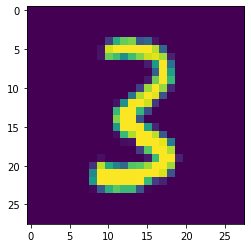

In [106]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [107]:
model, opt = get_model()

In [108]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [109]:
fit()

# Random Sampling

In [110]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [111]:
small_ds = Dataset(*train_ds[:10])

In [112]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [113]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([5, 1, 7]), tensor([9, 4, 6]), tensor([8, 2, 3]), tensor([0])]

In [114]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [115]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [116]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

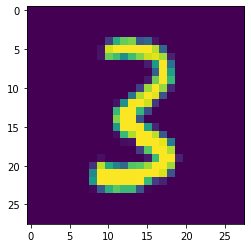

In [117]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

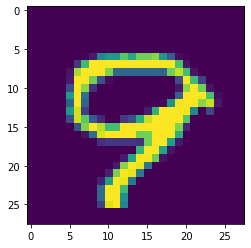

In [118]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

# Pytorch DataLoader

In [119]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [120]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=RandomSampler(valid_ds), collate_fn=collate)

In [121]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2373, grad_fn=<NllLossBackward>), tensor(0.9219))

In [122]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [123]:
model, opt = get_model()
fit()
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

# DataBunch/Learner

In [124]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [125]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [126]:
def get_dls(train_ds, valid_ds, bs):
        return DataLoader(train_ds, batch_size=bs), DataLoader(valid_ds, batch_size=bs)

In [127]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [128]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model,opt,loss_func,data

In [129]:
learn = Learner(*get_model(data), loss_func, data)

In [130]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb, yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0.,0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy(pred, yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [131]:
loss,acc = fit(1, learn)

0 tensor(0.1796) tensor(0.9487)


In [132]:
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb, yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()
        
def all_batches(dl, cb):
    for xb, yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return
        
def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
            
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [133]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [134]:
class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []
        
    def begin_fit(self, learn):
        self.learn, self.in_train = learn, True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res
    
    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res
    
    def begin_validate(self):
        self.learn.model.eval()
        self.in_train = False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res
    
    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res
    
    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res
    
    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return learn.stop
        finally: learn.stop = False
            

In [135]:
class TestCallback(Callback):
    def begin_fit(self, learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True
    
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        if self.n_iters >= 10: learn.stop = True
        return True

In [136]:
fit(1, learn, cb=CallbackHandler([TestCallback()]))

1
2
3
4
5
6
7
8
9
10


In [137]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [138]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0
        self.run.n_iter=0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1/self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [139]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        if self.n_iters>=10: return True

In [140]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [141]:
TrainEvalCallback().name

'train_eval'

In [142]:
from collections import Iterable

In [143]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

In [144]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs
        
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
            self.stop=False
            
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        
        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
                    
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x:x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [145]:
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0,0
        self.tot_mets = [0] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)


In [146]:
learn = Learner(*get_model(data), loss_func, data)

In [147]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [148]:
run.fit(2, learn)

train: [0.3193307421875, tensor(0.9030)]
valid: [0.191325, tensor(0.9438)]
train: [0.147208212890625, tensor(0.9567)]
valid: [0.1471210205078125, tensor(0.9571)]


In [149]:
loss, acc = stats.valid_stats.avg_stats
assert acc > 0.9
loss, acc

(0.1471210205078125, tensor(0.9571))

In [150]:
from functools import partial

In [151]:
acc_cbf = partial(AvgStatsCallback, accuracy)

In [152]:
run = Runner(cb_funcs=acc_cbf)

In [153]:
run.fit(1, learn)

train: [0.11233595703125, tensor(0.9670)]
valid: [0.147654833984375, tensor(0.9586)]


# Initial setup

In [154]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [155]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [156]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [157]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.71321296875, tensor(0.7910)]
valid: [0.3655104248046875, tensor(0.8902)]
train: [0.31061857421875, tensor(0.9095)]
valid: [0.2642591064453125, tensor(0.9243)]
train: [0.24837853515625, tensor(0.9289)]
valid: [0.2152605224609375, tensor(0.9396)]


In [158]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.758364296875, tensor(0.8028)]
valid: [0.3925489501953125, tensor(0.8869)]
train: [0.356886328125, tensor(0.8976)]
valid: [0.3151582275390625, tensor(0.9090)]
train: [0.306908359375, tensor(0.9119)]
valid: [0.2719412841796875, tensor(0.9229)]


In [159]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [160]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [],[]
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_param()

In [161]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [162]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [163]:
f = sched_lin(1,2)
f(0.3)

1.3

In [164]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

torch.Tensor.ndim = property(lambda x: len(x.shape))

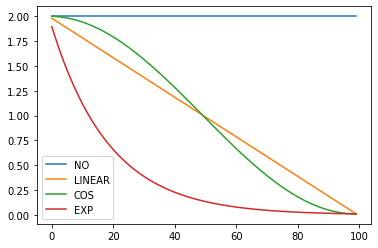

In [165]:
annealings = 'NO LINEAR COS EXP'.split()

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [166]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [167]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

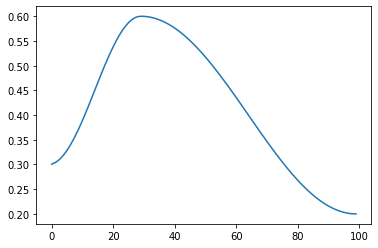

In [168]:
plt.plot(a, [sched(o) for o in p])

In [169]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [170]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [171]:
run.fit(3, learn)

train: [0.803401328125, tensor(0.7795)]
valid: [0.423475927734375, tensor(0.8677)]
train: [0.3167041796875, tensor(0.9073)]
valid: [0.249591162109375, tensor(0.9286)]
train: [0.246191640625, tensor(0.9300)]
valid: [0.21552998046875, tensor(0.9405)]


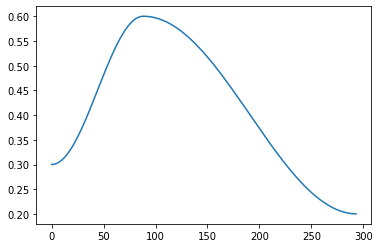

In [172]:
run.recorder.plot_lr()

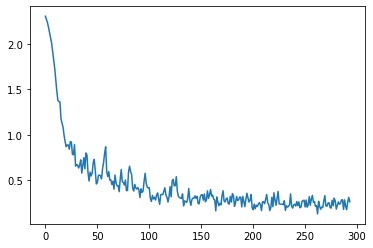

In [173]:
run.recorder.plot_loss()